# Ames Housing Project


## Project Challenge Statement

#### Goal: Predict the price of homes at sale for the Aimes Iowa Housing dataset. 

Two files used to build the model. 

- train_data_cleanna.csv -- this data contains all of the training data with no missing values and outliers
- test_data_cleanna.csv -- this data contains all of the testing data with no missing values and outlier


## Table of Contents 

This Notebook is broken down into different sections for analysis purpose. The following links are connected to differenct section within the Notebook for simple navigation. 

### Contents:
- [Ridge Tuning Model Features Analysis](#Ridge-Tuning-Model-Features-Analysis)
- [Linear Regression With Specific Features](#Linear-Regression-With-Specific-Features)
- [Recommendation](#Recommendation)

### Describtion 
In the previous Model Tuning Notebook, 4 models were build to predict Sale Price. The conclusion we made was that the Ridge Model gives the best prediction of Sale Price with features engineering such as Polynomial Features and TransformedTargetRegressor. However, for the purpose of understanding the most important features, we will use Lasso model in this Notebook. In this notebook, we are going to try to understand what some of the variables that have the strongest affect in predicting Sale Price. Based on what we understand from the data, we will provide recommendation to home owners on how to effeciently improve Sale Price for their home. 

In [61]:
#Eliminate warnings 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [62]:
# Library imports
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, RFECV
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


np.random.seed(42)
%matplotlib inline

In [63]:
from functions import *

In [64]:
#import Data 
clean_train_data = pd.read_csv('../datasets/train_data_clean.csv')
clean_test_data = pd.read_csv('../datasets/test_data_clean.csv')

base_train_data = pd.read_csv('../datasets/train_data_cleanna.csv')
base_test_data = pd.read_csv('../datasets/test_data_cleanna.csv')

In [65]:
#Extract common values in X_train and X_test values for X Variables 
p_cols = ['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond',
       'Year Built', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Garage Area', 'Wood Deck SF', 'Screen Porch', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_NAmes',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_StoneBr', 'Exterior 1st_BrkFace',
       'Garage Cond_Ex']

In [66]:
#Categorical Values for getting Dummy
X_dummy = ext_cat_features(base_train_data)

## Lasso Tuning Model Features Analysis

### Lasso Model for Features Extraction

In [67]:
X = pd.get_dummies(base_train_data, columns = X_dummy).drop(columns = ['Unnamed: 0', 'Id','PID', 'SalePrice'])
y = base_train_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [68]:
#Lasso pipeline 
pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('var_thresh', VarianceThreshold(.05)),
    ('ss', StandardScaler()),
    ('tt', TransformedTargetRegressor(regressor = RidgeCV(), func=np.log, inverse_func=np.exp))
])

In [69]:
pipe.fit(X_train[p_cols], y_train)
pipe_predict = pipe.predict(X_test[p_cols])
print("train score", pipe.score(X_train[p_cols], y_train))
print('test score', pipe.score(X_test[p_cols], y_test))
print("R2 score", r2_score(pipe_predict, y_test));

train score 0.9472064454826928
test score 0.9017416969300243
R2 score 0.8924766088885087


In [70]:
## Build a gride 
param_grid = {
    'var_thresh__threshold': [0, .05, .1, .25],
    'tt__regressor' : [RidgeCV(), LassoCV()]
}

In [71]:
gs = GridSearchCV(pipe, param_grid)

In [72]:
gs.fit(X_train[p_cols], y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('var_thresh', VarianceThreshold(threshold=0.05)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('tt', TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log'>,
              inve..._mode=None, normalize=False, scoring=None, store_cv_values=False),
              transformer=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'var_thresh__threshold': [0, 0.05, 0.1, 0.25], 'tt__regressor': [RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False), LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyc

In [107]:
gs.best_estimator_.named_steps['tt']

TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log'>,
              inverse_func=<ufunc 'exp'>,
              regressor=LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
              transformer=None)

In [73]:
gs.best_estimator_.named_steps['var_thresh']

VarianceThreshold(threshold=0.25)

In [74]:
gs.best_estimator_.named_steps['poly'].transform(X_train[p_cols])

array([[1.0700e+02, 1.2888e+04, 7.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0000e+01, 7.2000e+03, 5.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.5000e+01, 1.0655e+04, 8.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [4.2000e+01, 3.9640e+03, 6.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [9.4000e+01, 9.2590e+03, 4.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.0000e+01, 9.1000e+03, 7.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

### Extract the Coeficient and Variables names 

In [75]:
#Extract the coeficient and variables names 
mask = gs.best_estimator_.named_steps['var_thresh'].get_support()
coefs = gs.best_estimator_.named_steps['tt'].regressor_.coef_
poly_data = gs.best_estimator_.named_steps['poly'].transform(X_train[p_cols])
poly_cols = gs.best_estimator_.named_steps['poly'].get_feature_names(X_train[p_cols].columns)

#Dataframe with column names 
poly_data = pd.DataFrame(poly_data, columns = poly_cols)
poly_data.head(10)

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,2nd Flr SF,...,Neighborhood_Sawyer^2,Neighborhood_Sawyer Neighborhood_StoneBr,Neighborhood_Sawyer Exterior 1st_BrkFace,Neighborhood_Sawyer Garage Cond_Ex,Neighborhood_StoneBr^2,Neighborhood_StoneBr Exterior 1st_BrkFace,Neighborhood_StoneBr Garage Cond_Ex,Exterior 1st_BrkFace^2,Exterior 1st_BrkFace Garage Cond_Ex,Garage Cond_Ex^2
0,107.000000,12888.0,7.0,8.0,1937.0,0.0,288.0,1005.0,1262.0,1005.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,60.000000,7200.0,5.0,8.0,1950.0,0.0,398.0,864.0,864.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,85.000000,10655.0,8.0,5.0,2003.0,296.0,1124.0,3206.0,1629.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,68.878999,11929.0,8.0,7.0,1995.0,466.0,0.0,1242.0,1251.0,1250.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,60.000000,9900.0,6.0,7.0,1940.0,0.0,0.0,778.0,944.0,545.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,58.000000,6451.0,7.0,7.0,1900.0,0.0,208.0,712.0,848.0,580.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,68.878999,14860.0,8.0,5.0,2002.0,240.0,1538.0,1778.0,1786.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,70.000000,12886.0,5.0,6.0,1963.0,0.0,444.0,520.0,1464.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,75.000000,9060.0,6.0,5.0,1957.0,327.0,0.0,967.0,967.0,671.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,60.000000,10800.0,7.0,7.0,1914.0,0.0,390.0,880.0,880.0,888.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
coef_df = pd.DataFrame([coefs, poly_cols]).T.set_index(1)
coef_df.columns = ['Coef']
coef_df.head(10)

,Coef
1,
Lot Frontage,0
Lot Area,0.0179793
Overall Qual,0.0883427
Overall Cond,0.0471635
Year Built,0.08103
Mas Vnr Area,0
BsmtFin SF 1,0.0849193
Total Bsmt SF,0.0904305
1st Flr SF,0.14173


In [77]:
coef_df["Coef"].sort_values(ascending = True)[:20]

1
Total Bsmt SF Kitchen AbvGr           -0.0788684
Total Bsmt SF Garage Area             -0.0477789
BsmtFin SF 1 Neighborhood_NoRidge     -0.0431041
Lot Frontage Exterior 1st_BrkFace     -0.0354583
BsmtFin SF 1 Neighborhood_OldTown     -0.0287733
Overall Qual Neighborhood_Sawyer      -0.0225443
BsmtFin SF 1 Kitchen AbvGr             -0.022284
Mas Vnr Area Neighborhood_Edwards      -0.021226
Lot Frontage 1st Flr SF               -0.0133814
Neighborhood_Edwards                  -0.0130678
Mas Vnr Area Neighborhood_NWAmes      -0.0127395
2nd Flr SF Neighborhood_StoneBr        -0.012598
BsmtFin SF 1 Total Bsmt SF            -0.0123312
Mas Vnr Area Neighborhood_NAmes       -0.0123267
1st Flr SF Neighborhood_Sawyer        -0.0119232
Mas Vnr Area Neighborhood_SWISU       -0.0113273
Overall Qual Year Built               -0.0111915
Total Bsmt SF Neighborhood_NridgHt    -0.0103356
BsmtFin SF 1 Neighborhood_SWISU       -0.0103287
1st Flr SF Neighborhood_Edwards      -0.00992513
Name: Coef, dtype:

In [78]:
coef_df["Coef"].sort_values(ascending = False)[:20]

1
1st Flr SF                             0.14173
2nd Flr SF                            0.116462
Total Bsmt SF                        0.0904305
Overall Qual                         0.0883427
BsmtFin SF 1                         0.0849193
Year Built                             0.08103
Overall Qual Neighborhood_NoRidge    0.0613173
Overall Cond Neighborhood_Gilbert     0.050958
Overall Cond                         0.0471635
Lot Frontage Neighborhood_Gilbert    0.0468045
Overall Cond Exterior 1st_BrkFace    0.0450946
2nd Flr SF Garage Cond_Ex            0.0396035
Kitchen AbvGr                        0.0335408
Lot Area Neighborhood_Gilbert        0.0267725
Total Bsmt SF Neighborhood_NWAmes    0.0264205
Neighborhood_Sawyer                  0.0258809
Lot Area                             0.0179793
Lot Frontage Bedroom AbvGr           0.0178476
Overall Cond Garage Area             0.0160742
Lot Frontage Lot Area                0.0151477
Name: Coef, dtype: object

In [94]:
upper_col = coef_df["Coef"].sort_values(ascending = True)[:30].index
lower_col = coef_df["Coef"].sort_values(ascending = False)[:30].index

In [95]:
poly_data[upper_col.append(lower_col)].shape

(1536, 60)

## Linear Regression With Specific Features

In this section, we are going to use the significant features to build Linear Regression Model to check the significance of their P_value and understand which ones are the most important features. 


In [96]:
poly_data[upper_col.append(lower_col)].shape, y_train.shape

((1536, 60), (1536,))

In [97]:
#take log of Y
# y_train = np.log(y_train)
# y_train[:10]

In [98]:
X = poly_data[upper_col.append(lower_col)].reset_index()
y = y_train.reset_index().drop(columns = 'index')

In [99]:
#standard scaling
ss = StandardScaler()
X_ss = ss.fit_transform(X)
X_ss = pd.DataFrame(X_ss, columns =  X.columns)

In [100]:
#Fit linear Regression model for X columns from above and y 
X = X_ss
X = X = sm.add_constant(X)
y = y

In [101]:
#Fit linear model again to check selected columns 
OLS = sm.OLS(y, X)
results = OLS.fit()

In [102]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     262.4
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        10:22:24   Log-Likelihood:                -17618.
No. Observations:                1536   AIC:                         3.536e+04
Df Residuals:                    1475   BIC:                         3.568e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               1.815e+05    603.597    300.674      0.000     1.8e+05    1.83e+05
index                                652.8027    617.290      1.058      0.290    -558.057    1863.663
Total Bsmt SF Kitchen AbvGr        -1186.0877   2908.647     -0.408      0.683   -6891.612    4519.437
Total Bsmt SF Garage Area           9651.4704   2841.387      3.397      0.001    4077.881    1.52e+04
BsmtFin SF 1 Neighborhood_NoRidge  -3890.7588   1374.191     -2.831      0.005   -6586.335   -1195.182
Lot Frontage Exterior 1st_BrkFace  -1210.0021   2277.887     -0.531      0.595   -5678.245    3258.241
BsmtFin SF 1 Neighborhood_OldTown  -2421.7416    643.783     -3.762      0.000   -3684.569   -1158.914
Overall Qual Neighborhood_Sawyer   -1.099e+04   5080.624     -2.162      0.031    -2.1e+04   -1019.958
BsmtFin SF 1 Kitchen AbvGr         -3537.4041   3655.337     -0.968      0.333   -1.07e+04    3632.809
Mas Vnr Area Neighborhood_Edwards   -881.8714    729.526     -1.209      0.227   -2312.891     549.148
Lot Frontage 1st Flr SF             4169.6414   3832.652      1.088      0.277   -3348.388    1.17e+04
Neighborhood_Edwards                  36.7242   1981.124      0.019      0.985   -3849.397    3922.845
Mas Vnr Area Neighborhood_NWAmes    -608.9916    965.897     -0.630      0.528   -2503.669    1285.686
2nd Flr SF Neighborhood_StoneBr     6005.4785    857.964      7.000      0.000    4322.518    7688.438
BsmtFin SF 1 Total Bsmt SF          1.341e+04   2629.076      5.101      0.000    8252.973    1.86e+04
Mas Vnr Area Neighborhood_NAmes     -959.8816    714.736     -1.343      0.179   -2361.888     442.125
1st Flr SF Neighborhood_Sawyer     -5393.7365   2746.180     -1.964      0.050   -1.08e+04      -6.901
Mas Vnr Area Neighborhood_SWISU      477.2182    639.672      0.746      0.456    -777.546    1731.982
Overall Qual Year Built              4.86e+05   5.48e+04      8.872      0.000    3.79e+05    5.93e+05
Total Bsmt SF Neighborhood_NridgHt  8811.5019   3038.535      2.900      0.004    2851.192    1.48e+04
BsmtFin SF 1 Neighborhood_SWISU     -808.4402    857.295     -0.943      0.346   -2490.088     873.208
1st Flr SF Neighborhood_Edwards     -909.1836   1994.423     -0.456      0.649   -4821.392    3003.025
Lot Frontage Screen Porch           4787.1755    631.320      7.583      0.000    3548.795    6025.557
Lot Frontage Neighborhood_SWISU      865.6709    882.241      0.981      0.327    -864.911    2596.253
1st Flr SF Neighborhood_NoRidge     7064.0072   3010.457      2.346      0.019    1158.774     1.3e+04
Total Bsmt SF Neighborhood_StoneBr  1.401e+04   2726.529      5.139      0.000    8664.620    1.94e+04
1st Flr SF Exterior 1st_BrkFace    -1930.0235   2039.525     -0.946      0.344   -5930.703    20

In [105]:
#significant variables 
results.pvalues[results.pvalues < 0.05].sort_values(ascending = True)

const                                 0.000000e+00
2nd Flr SF                            4.062677e-83
Overall Qual Year Built               2.026620e-18
Overall Qual                          3.796766e-17
Lot Frontage Screen Porch             5.951048e-14
1st Flr SF                            3.913193e-13
2nd Flr SF Neighborhood_StoneBr       3.882170e-12
2nd Flr SF Garage Cond_Ex             4.456751e-09
Lot Area Overall Cond                 1.298007e-07
Total Bsmt SF Neighborhood_StoneBr    3.123931e-07
BsmtFin SF 1 Total Bsmt SF            3.823339e-07
Year Built                            1.460503e-06
Overall Cond Neighborhood_StoneBr     7.620050e-05
BsmtFin SF 1 Neighborhood_OldTown     1.753418e-04
Year Built Bedroom AbvGr              2.428748e-04
Total Bsmt SF Garage Area             7.000555e-04
Total Bsmt SF Neighborhood_NridgHt    3.787882e-03
Lot Frontage Lot Area                 4.471519e-03
BsmtFin SF 1 Neighborhood_NoRidge     4.698714e-03
Neighborhood_Sawyer            

## Recommendation

In this section, the following questions will be answered for the purpose of providing useful insght to improve sale price:

- Which features appear to add the most value to a home?
    - overall condition 
    - second floor SF
    - lot area
    - first floor SF
- Which features hurt the value of a home the most?
    - year build, the older the house, the cheaper the house 
- What are things that homeowners could improve in their homes to increase the value?
    - people really value 2nd floor, the larger the 2nd floor, the higher the sale price 
    - specially true in Stonebar
    - imporving in overall quality will also increase the house value 
    - lot area is also significant, positive relationship with saleprice 
    - expand total basement and garage area will boost house values 
- What neighborhoods seem like they might be a good investment?
    - stonebr with second floor, significant positive correlation with Sale Price 
    - neightbourhood sawyer is positively correlated with saleprice 
    - Nridghrt neighourhood 
- Do you feel that this model will generalize to other cities? How could you revise your model to make it more universal OR what date would you need from another city to make a comparable model?

According to our analysis, there are few variables have significantly high positive correlation with the Sale Price of ones house. First is the overall condition of the house. The p-value of overall condition variable is less than 0.05 which means we will reject the null hypothesis of saying there is no relationship between overall condition and sale price. As the overall condition of the house increases, the sale price of the house increase as well. Meanwhile, Lot area, Lot Frontage Lot Area, square foot first and second floor of the house also have a high correlation with the Sale Price. In other word, the larger the space of the house is, the higher the sale price will be. The third feature that contributes to increase in sale price is overall quality with year built. If a house is built recently, and the quality of the house is good, the sale price of the house will be higher. 

Within the features that have low p-values, few variables such as 2nd Flr SF Neighborhood_StoneBr, Total Bsmt SF Neighborhood_NridgHt , Overall Qual Neighborhood_Sawyer, and Total Bsmt SF Neighborhood_NWAmes point us to the direction of understaning the importance of neighbourhoods. Especially variable Neighborhood_Sawyer, which has a possitive correlation with Sale Price, means that if your house is in this neighourhood, the Sale Price of the house will go up. 

As for the features that decreases the Sale Price of the house, One interaction term caught my eye: Lot Frontage Bedroom AbvGr, which is an interaction term between Lot Frontage and number of bedrooms above ground. This interaction term is significant and has a negative relationship with the Sale Price. However, we can't draw any conclusion about lot frontage and bedroom only base on this one variable. This negative relationship between the interaction term and saleprice could be a compensation to adjust the real relationship between variables due the fact that both Lot Frontage and Bedroom above ground have positive correlation with saleprice. 

Based on the analysis above, we will provide the following business recommendation for those who is interested in boosting their house sale price. First, understand that some neighbourhoods are more simply more expensive then others. If one is interested in boosting housing value in a particular neighbourhood, we can perform furthur analysis by extracting information based on the particular neighbourhood. However, for everyone who already has a house and looking forward to improve the price regardless of location, there are things you can do. If your house has a second floor, this feature will add a lot of value in boosting saleprice. If you do not have a second floor, there are ways for you to improve values as well. After all, the quality and condition of the house is extremely important for buyers. Therefore, before selling the house, fixing up the house such as painting the wall, fixing up the pipe, and so on, will add value to the sale price.  

Text(0.5, 1.0, 'Overall Qual vs Sale Price')

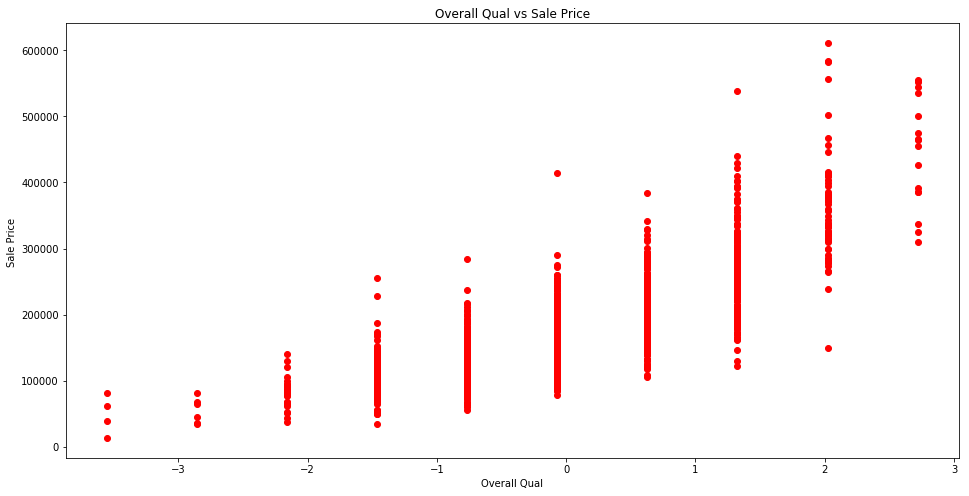

In [115]:
plt.figure (figsize = (16,8))
plt.scatter(X['Overall Qual'], y, color = 'red')
plt.xlabel('Overall Qual')
plt.ylabel("Sale Price ")
plt.title("Overall Qual vs Sale Price")

Text(0.5, 1.0, 'Year Built vs Sale Price')

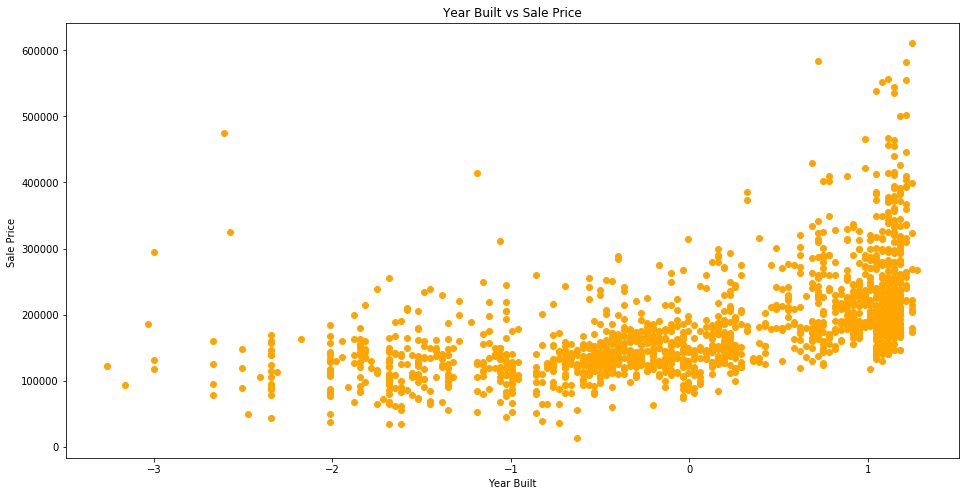

In [113]:
plt.figure (figsize = (16,8))
plt.scatter(X['Year Built'], y, color = 'orange')
plt.xlabel('Year Built')
plt.ylabel("Sale Price ")
plt.title("Year Built vs Sale Price")

Text(0.5, 1.0, 'Overall Qual Year Built vs Sale Price')

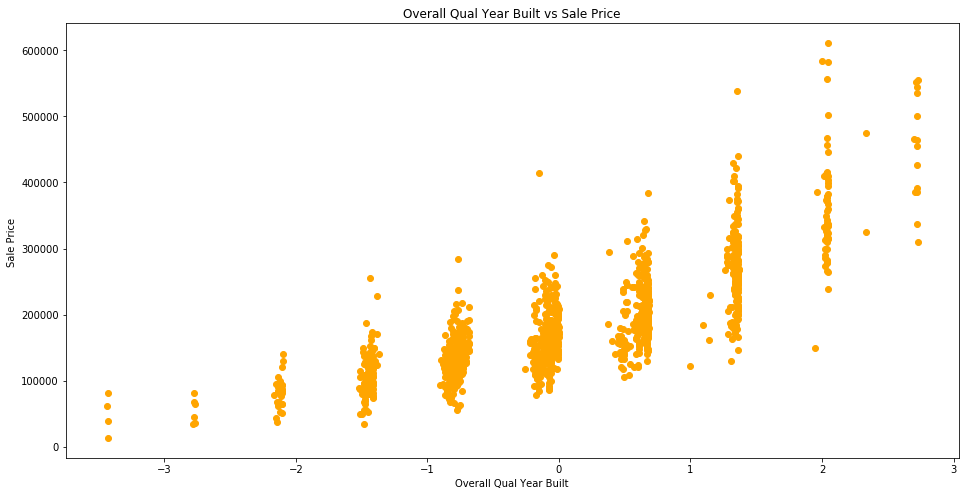

In [116]:
plt.figure (figsize = (16,8))
plt.scatter(X['Overall Qual Year Built'], y, color = 'orange')
plt.xlabel('Overall Qual Year Built')
plt.ylabel("Sale Price ")
plt.title("Overall Qual Year Built vs Sale Price")